# CROSS VALIDATION SCORES TOO GOOD TO BE TRUE

#### The Cross Val results for Ridge LogisticRegression are returning the exact same values for most of the regularization parameter "C" (unless EXTREMELY small).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
#url='https://www.kaggle.com/kemical/kickstarter-projects/downloads/ks-projects-201801.csv'
#df=pd.read_csv(url, header=None)

In [3]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

https://www.kaggle.com/kromel/kickstarter-successful-vs-failed/data

In [4]:
df=df.sample(1000, random_state=32)

In [5]:
df.shape

(1000, 15)

In [6]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
711859,292924641,"NextGen, Use any platform on any devive, rules...",Software,Technology,SEK,2014-11-04,50000,2014-10-21 15:14:46,0,failed,0,SE,0,0.00,6726.22
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,Fiction,Publishing,USD,2012-07-12,1000,2012-06-28 01:35:01,1505,successful,43,US,1505,1505.00,1000.00
305960,1549399998,· Guenda · products for connecting with nature...,Embroidery,Crafts,MXN,2017-12-25,60000.00,2017-11-25 15:56:14,60520.00,successful,84,MX,112.64,3067.57,3041.21
56190,1111918633,The ABCs of Nightmares,Children's Books,Publishing,CAD,2016-11-24,8500.00,2016-10-24 01:05:08,2764.00,failed,49,CA,0,2048.77,6300.50
867977,7.40164e+08,The Toughest,Documentary,Film & Video,USD,2016-04-02,2295.00,2016-03-03 15:46:40,0.00,failed,0,US,0,0.00,2295.00


In [7]:
df.dtypes

ID                   object
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                 object
launched             object
pledged              object
state                object
backers              object
country              object
usd pledged          object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

# Data Cleaning

### Nulls

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
df_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(df_missingData.head(20))
df.isnull().sum().max()

,Total,Percent
usd pledged,8,0.008
usd_goal_real,0,0.000
usd_pledged_real,0,0.000
country,0,0.000
backers,0,0.000
state,0,0.000
pledged,0,0.000
launched,0,0.000
goal,0,0.000
deadline,0,0.000


8

In [9]:
dfNoNulls = df.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", df.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", df.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/df.shape[0]))   

Before Dropping Nulls:  1000
After Dropping Nulls:  992
Rows Removed:  8
Percent Removed: 1%


### "usd pledged" Column: Bad Formatting

In [10]:
dfDropPldg = dfNoNulls.copy()
for row in dfDropPldg.iterrows():
    if str(row[1]['usd pledged']).count('.') > 1:
        print (row)
        dfDrop = dfDropPldg.drop(row[0])
        break;
# Use a comprehension for this

In [11]:
dfDropCntry = dfDropPldg.copy()
dfDropCntry = dfDropCntry.drop(dfDropCntry[(dfDropCntry['country'] != 'US')].index)

In [12]:
dfDropCat = dfDropCntry.copy()
dfDropCat = dfDropCat.drop('category',axis=1)

In [13]:
dfDropState = dfDropCat.copy()
dropVals = ['live','suspended','canceled','fnceled']
for dv in dropVals:
    dfDropState = dfDropState.drop(dfDropState[(dfDropState['state'] == dv)].index)

### Convert to Numeric

In [14]:
dfNum = dfDropState.copy()
numCols = ['goal','pledged','backers','usd pledged']
for c in numCols:
    dfNum[c] = dfNum[c].apply(pd.to_numeric)

In [15]:
dfNum.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000,7.000000e+02
mean,2.324955e+04,8470.745529,120.361429,6414.505000,8470.745529,2.324955e+04
std,1.286013e+05,31772.481735,492.706359,27647.878257,31772.481735,1.286013e+05
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,2.000000e+03,81.000000,3.000000,35.000000,81.000000,2.000000e+03
50%,5.000000e+03,1102.500000,20.000000,802.000000,1102.500000,5.000000e+03
75%,1.500000e+04,5208.500000,71.000000,4067.750000,5208.500000,1.500000e+04
max,3.000000e+06,588903.000000,9677.000000,588903.000000,588903.000000,3.000000e+06


# Encoding

In [16]:
sorted(dfNum.state.unique())

['failed', 'successful']

In [17]:
dfEnc = pd.DataFrame()
dfEnc = dfNum.copy()
dfEnc['state'] = dfNum.state.astype('category')
dfEnc['state_code'] = np.where(dfEnc['state'].str.contains('successful'),1,0)

In [18]:
dfEnc = pd.get_dummies(dfEnc, columns=['main_category'], prefix = ['cat'])

In [19]:
dfEnc.shape

(700, 29)

In [20]:
dfEnc.reset_index(inplace=True, drop=True)

# Helper Functions

In [21]:
def BoxHist(column, df_focus):
    
    sns.set()
    colList = df_focus[column]
    
    # plots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=column, data=df_focus)
    
    plt.subplot(1, 2, 2)
    g=sns.distplot(colList, kde=False, bins=60)
    
    # rotate label for large tick values on histagram x axis
    if (colList.max() > 9999):
        plt.setp(g.get_xticklabels(), rotation=45)

    plt.show()

In [22]:
def loopIterations2(X,y,listOfCs,verbose=False):

    for c in listOfCs:

        IterRdgLr = LogisticRegression(C=c, penalty='l2').fit(X,y)
        score = IterRdgLr.score(X,y)
        cvs = cross_val_score(IterRdgLr, X,y, cv=5)
        # Display.
        if verbose:
            print('===========================')
        print("C:{0}\n Score:{1}".format(c,score))
        print (" CVS:\n  {}".format(cvs))
        if verbose:
            print('\nCoefficients:')
            print(IterRdgLr.coef_)
            print('\nIntercept:')
            print(IterRdgLr.intercept_)

            pred_y_sklearn = IterRdgLr.predict(X)
            print('\nAccuracy CrossTab:')
            print(pd.crosstab(pred_y_sklearn, y))

In [23]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Isolate the Issue Columns

In [24]:
dfIsolate = dfEnc[['state_code','goal','pledged','backers']].copy()

# Many Outliers

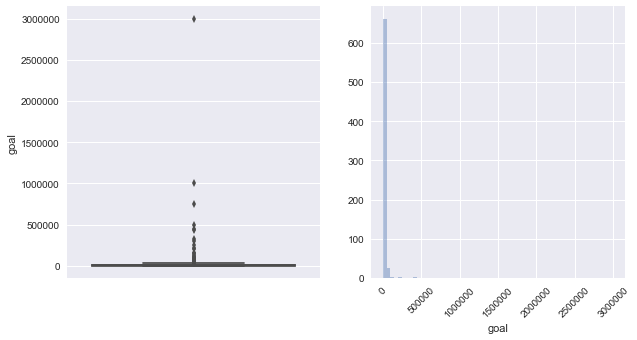

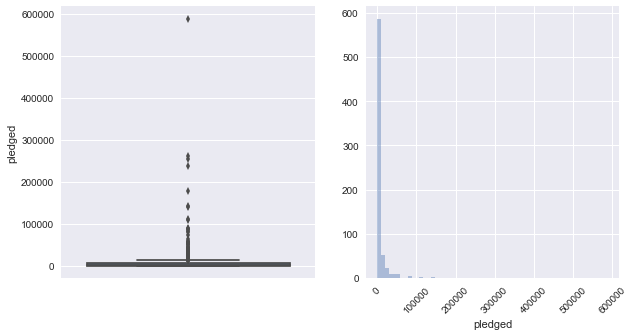

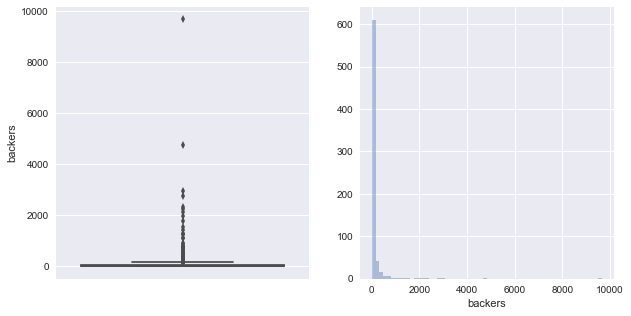

In [25]:
contCols = ['goal','pledged','backers']
for col in contCols:
    BoxHist(col,dfIsolate)

# Weak Correlation

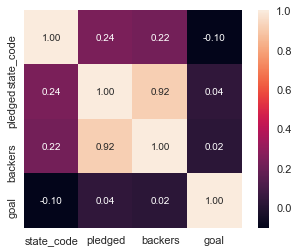

In [26]:
corrmat = dfIsolate.corr()
k = 10
cols = corrmat.nlargest(k, 'state_code')['state_code'].index
cm = np.corrcoef(dfIsolate[cols].values.T)
sns.set(font_scale=1.1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Target Balance

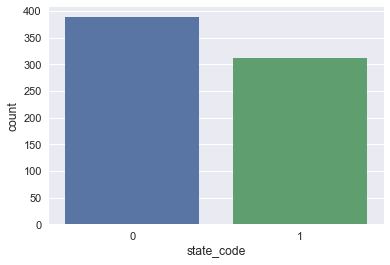

In [27]:
sns.countplot(x=dfIsolate['state_code'],data=dfIsolate)
plt.show()

# Target Division Exploration

In [28]:
dfTrue = dfIsolate.copy()
dfFalse = dfIsolate.copy()

dfTrue = dfIsolate[(dfIsolate.state_code == 1)]
dfFalse = dfIsolate[(dfIsolate.state_code == 0)]

In [29]:
display_side_by_side(dfTrue.describe(), dfFalse.describe())

,state_code,goal,pledged,backers
count,312.0,312.000000,312.000000,312.000000
mean,1.0,8339.089712,16957.225513,242.317308
std,0.0,14446.234417,45721.908396,715.389597
min,1.0,1.000000,31.000000,1.000000
25%,1.0,1500.000000,2078.422500,32.000000
50%,1.0,3500.000000,5005.500000,70.500000
75%,1.0,10000.000000,13319.327500,164.250000
max,1.0,135000.000000,588903.000000,9677.000000
,state_code,goal,pledged,backers
count,388.0,3.880000e+02,388.000000,388.000000


### Goal: True vs False

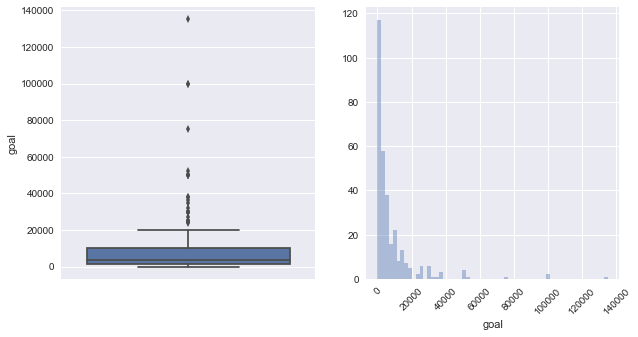

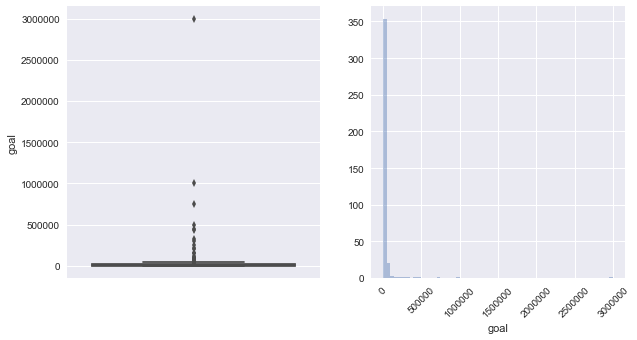

In [30]:
BoxHist('goal',dfTrue)
BoxHist('goal',dfFalse)

### Pledged: True vs False

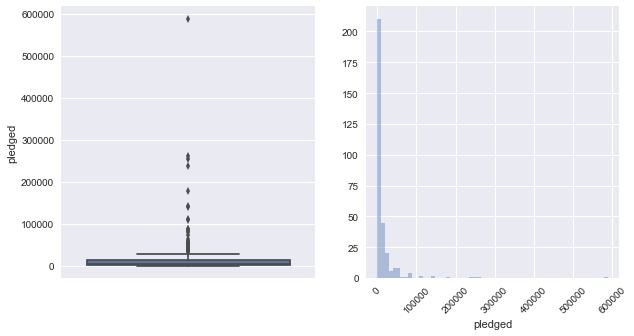

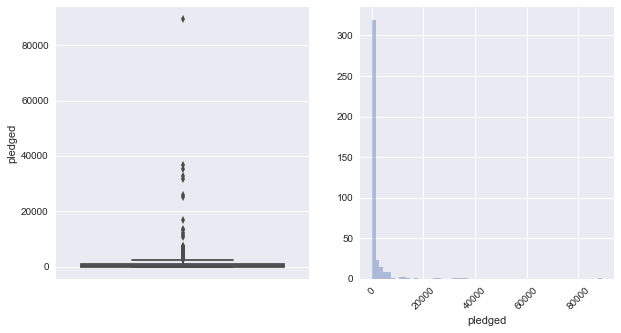

In [31]:
BoxHist('pledged',dfTrue)
BoxHist('pledged',dfFalse)

### Backers: True vs False

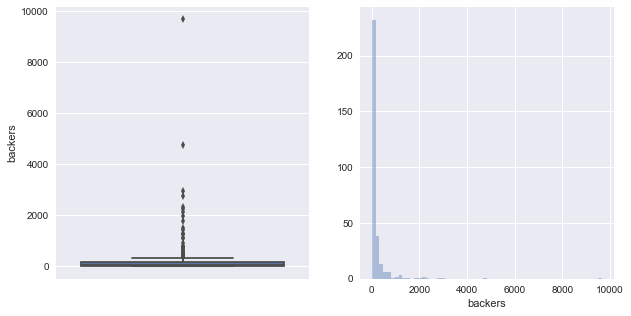

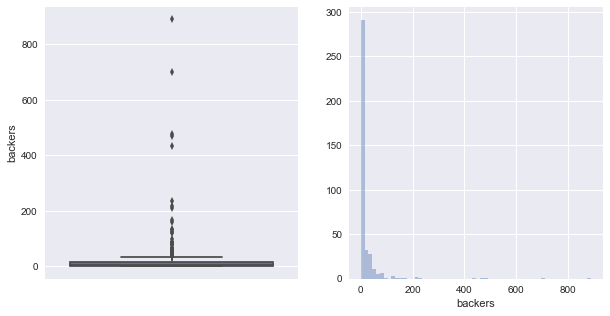

In [32]:
BoxHist('backers',dfTrue)
BoxHist('backers',dfFalse)

# CORRELATION: True vs False

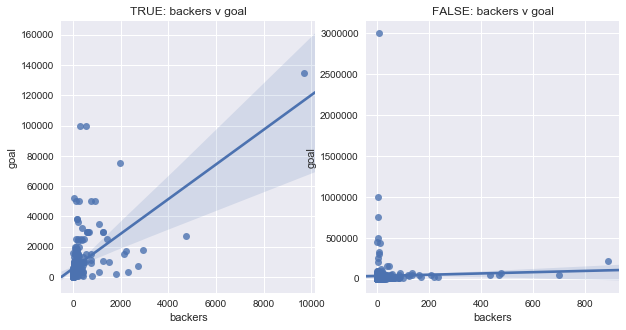

In [33]:
# plots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
ax = sns.regplot(x='backers',y='goal', data=dfTrue)
ax.set_title('TRUE: backers v goal')
    
plt.subplot(1, 2, 2)
ax = sns.regplot(x='backers',y='goal', data=dfFalse)
ax.set_title('FALSE: backers v goal')
plt.show()

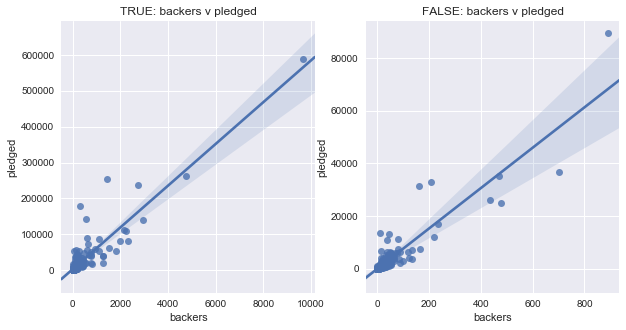

In [34]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
ax = sns.regplot(x='backers',y='pledged', data=dfTrue)
ax.set_title('TRUE: backers v pledged')
    
plt.subplot(1, 2, 2)
ax = sns.regplot(x='backers',y='pledged', data=dfFalse)
ax.set_title('FALSE: backers v pledged')
plt.show()

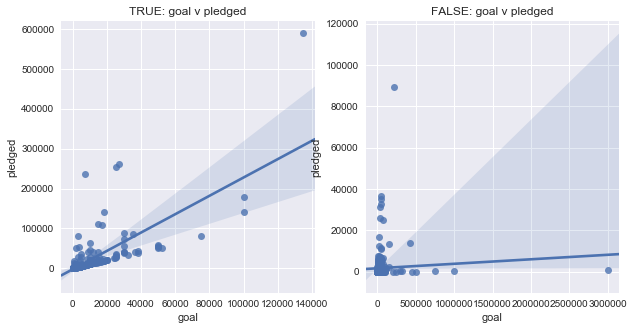

In [35]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
ax = sns.regplot(x='goal',y='pledged', data=dfTrue)
ax.set_title('TRUE: goal v pledged')
    
plt.subplot(1, 2, 2)
ax = sns.regplot(x='goal',y='pledged', data=dfFalse)
ax.set_title('FALSE: goal v pledged')
plt.show()

# Set Target and Data

In [36]:
X = dfIsolate.drop('state_code', axis=1)
y = dfIsolate['state_code']

# Issue EXAMPLE

In [37]:
B_rdgLr3 = LogisticRegression(C=300, penalty='l2').fit(X,y)
print('300\t' + str(B_rdgLr3.score(X,y)))

    
B_rdgLr5 = LogisticRegression(C=.003, penalty='l2').fit(X,y)
print('.003\t' + str(B_rdgLr5.score(X,y)))

    
B_rdgLr5 = LogisticRegression(C=.00003, penalty='l2').fit(X,y)
print('.00003\t' + str(B_rdgLr5.score(X,y)))

B_rdgLr5 = LogisticRegression(C=.000000000003, penalty='l2').fit(X,y)
print('.0000000003\t' + str(B_rdgLr5.score(X,y)))

300	1.0
.003	1.0
.00003	1.0
.0000000003	0.862857142857


# More Details on Cs

In [38]:
listOfCs = [300,.003,.00003,.000000000003]
loopIterations2(X,y,listOfCs, verbose=True)

C:300
 Score:1.0
 CVS:
  [ 1.          1.          1.          1.          0.99280576]

Coefficients:
[[-0.04378602  0.05157578  0.00363444]]

Intercept:
[ 0.0004377]

Accuracy CrossTab:
state_code    0    1
row_0               
0           388    0
1             0  312
C:0.003
 Score:1.0
 CVS:
  [ 1.          1.          1.          1.          0.99280576]

Coefficients:
[[-0.03895599  0.04591977  0.00316042]]

Intercept:
[ 0.00039138]

Accuracy CrossTab:
state_code    0    1
row_0               
0           388    0
1             0  312
C:3e-05
 Score:1.0
 CVS:
  [ 1.          1.          1.          1.          0.99280576]

Coefficients:
[[-0.01216908  0.01433618  0.00060847]]

Intercept:
[  5.95852113e-05]

Accuracy CrossTab:
state_code    0    1
row_0               
0           388    0
1             0  312
C:3e-12
 Score:0.8628571428571429
 CVS:
  [ 1.          0.85815603  0.76428571  0.83453237  0.8057554 ]

Coefficients:
[[ -5.69559639e-06   5.35389755e-06   7.60173734e-08]]

I

# Other Models

### Model Class

In [48]:
import time
from sklearn.model_selection import cross_val_score

class Model(object):
    
    def __init__(self,name,X,Y,modelObj,**modelParams):
        self.params = modelParams
        self.modelObj = modelObj.set_params(**self.params)  
        self.name = name
        self.X = X
        self.Y = Y
        self.initValues()   
    
    def initValues(self):
        start = time.time()
        self.modObjFit = self.modelObj.fit(self.X, self.Y)
        end = time.time()
        self.timeToFit = end - start
        self.crossVal = cross_val_score(self.modelObj, self.X, self.Y, cv=5)
        self.crossValMean = np.mean(self.crossVal)
        self.crossValRange = max(self.crossVal) - min(self.crossVal)
         
    def performance(self, boxPlot=True):
        print ("Model:\t\t" + str(self.name))
        print ("CV Mean:\t" + str(self.crossValMean))
        print ("CV Range:\t" + str(self.crossValRange))
        print ("Train Time:\t" + str(self.timeToFit))
        print ("CV Scores: ")
        print (self.crossVal)
        if boxPlot:
            fig = plt.figure()
            title = "Performance: %s" % (self.name)
            fig.suptitle(title)
            ax = fig.add_subplot(111)
            plt.boxplot(self.crossVal)
            ax.set_xticklabels(self.name)
            plt.show()
    
    def compareBox(self,modelList,filter=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.crossVal)
        names.append(self.name)
        
        for rightModel in modelList:
            if filter > 0:
                if rightModel.crossVal.mean() > filter:
                    results.append(rightModel.crossVal)
                    names.append(rightModel.name)
            else:
                results.append(rightModel.crossVal)
                names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels,folds=False):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        cvNameList= []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToFit,
                                'CV Mean':model.crossValMean,
                                'CV Range': model.crossValRange}
            if folds:  
                buildCvNameList = False
                if not cvNameList:
                    buildCvNameList=True
                for idx,cv in enumerate(model.crossVal):
                    cvName = 'CV Fold ' + str(idx+1)
                    if buildCvNameList:
                        cvNameList.append(cvName)
                    dataRowForFrame[cvName] = cv
            dataForFrame.append(dataRowForFrame)
        colOrder = ['Name', 'CV Mean', 'CV Range', 'Time']
        colOrder += cvNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels)    

### Gradient Boost

Model:		Gradient Boost
CV Mean:	0.975713119474
CV Range:	0.0288283658787
Train Time:	0.10285592079162598
CV Scores: 
[ 0.9787234   0.96453901  0.99285714  0.97841727  0.96402878]


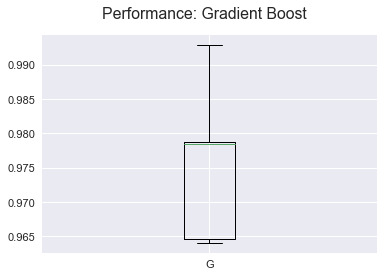

In [49]:
gbModelParams = {'n_estimators':140,
                 'max_depth':3,
                 'loss':'exponential'}
gbModel = Model('Gradient Boost',X,y,ensemble.GradientBoostingClassifier(),**gbModelParams)
gbModel.performance()

# Random Forrest

Model:		Random Forest
CV Mean:	0.982886954874
CV Range:	0.0283181357649
Train Time:	0.04292106628417969
CV Scores: 
[ 0.9858156   0.96453901  0.99285714  0.99280576  0.97841727]


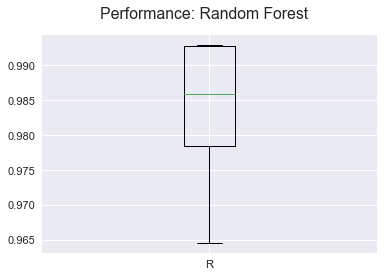

In [52]:
rfModelParams = {'n_estimators':21,
                 'max_depth':20,
                 'max_features':3,
                 'criterion':'entropy'}
rfModel = Model('Random Forest',X,y,ensemble.RandomForestClassifier(),**rfModelParams)
rfModel.performance()

### KNN

Model:		KNN
CV Mean:	0.99569373073
CV Range:	0.00719424460432
Train Time:	0.005707979202270508
CV Scores: 
[ 1.          1.          0.99285714  0.99280576  0.99280576]


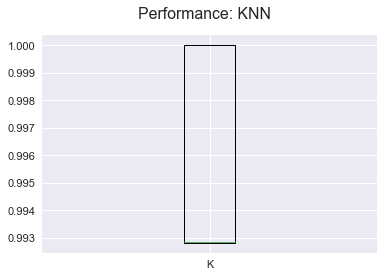

In [53]:
knnModelParams = {'n_neighbors': 1,
               'weights': 'distance'}
knnModel = Model('KNN',X,y,KNeighborsClassifier(),**knnModelParams)
knnModel.performance()

### Lasso

Model:		Lasso Reg
CV Mean:	0.995703862442
CV Range:	0.0143884892086
Train Time:	0.0487518310546875
CV Scores: 
[ 1.          0.9929078   1.          1.          0.98561151]


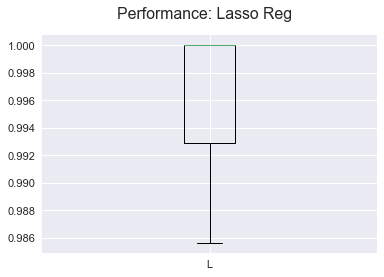

In [55]:
lassoRegModelParams = {'C':0.00314286,
               'penalty': 'l1'}
lassoRegModel = Model('Lasso Reg',X,y,LogisticRegression(),**lassoRegModelParams)
lassoRegModel.performance()

### Ridge

Model:		Ridge Reg
CV Mean:	0.998561151079
CV Range:	0.00719424460432
Train Time:	0.0035889148712158203
CV Scores: 
[ 1.          1.          1.          1.          0.99280576]


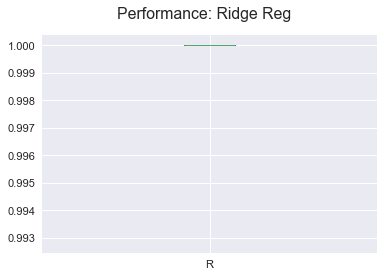

In [54]:
ridgeRegModelParams = {'C': .62,
               'penalty': 'l2'}
ridgeRegModel = Model('Ridge Reg',X,y,LogisticRegression(),**ridgeRegModelParams)
ridgeRegModel.performance()

### COMPARISON: All Models

,Name,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,Ridge Reg,0.998561,0.007194,0.003589,1.000000,1.000000,1.000000,1.000000,0.992806
1,Lasso Reg,0.995704,0.014388,0.048752,1.000000,0.992908,1.000000,1.000000,0.985612
2,KNN,0.995694,0.007194,0.005708,1.000000,1.000000,0.992857,0.992806,0.992806
3,Random Forest,0.982887,0.028318,0.042921,0.985816,0.964539,0.992857,0.992806,0.978417
4,Gradient Boost,0.975713,0.028828,0.102856,0.978723,0.964539,0.992857,0.978417,0.964029


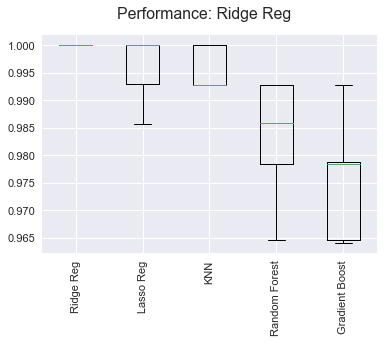

In [59]:
ridgeRegModel.fullCompareList([lassoRegModel, knnModel, rfModel, gbModel], folds=True)